In [3]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
from corner import corner

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import plot_util, overplot
from mejiro.utils import util

In [4]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'subhalo_detection_compare_dev')
detectable_halos = util.unpickle_all(save_dir, 'detectable_halos_', '.pkl')

z_list, m_list, c_list = [], [], []

for halo_list in detectable_halos:
    for z, m, c in halo_list:
        z_list.append(z)
        m_list.append(m)
        c_list.append(c)

m_list = [np.log10(m) for m in m_list]

In [5]:
len(detectable_halos)

1000

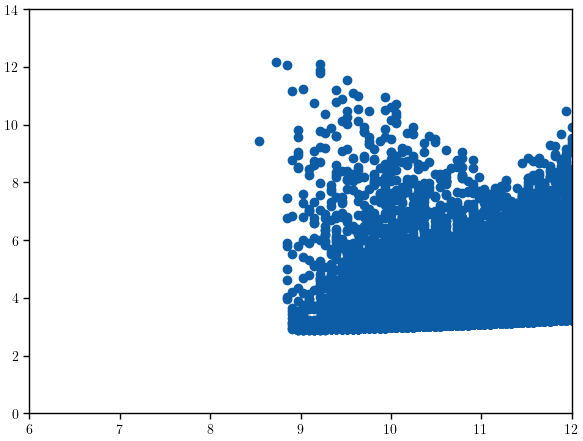

In [31]:
plt.scatter(m_list, c_list)
plt.xlim(6, 12)
plt.ylim(0, 14)
plt.show()

In [18]:
percent_det = []
mlog10_list = [np.log10(m) for m in np.logspace(6, 12, 100)]

for m in mlog10_list:
    count = np.sum(np.array(m_list) == m)
    percent_det.append(count / len(detectable_halos))

In [45]:
# Nightningale2023 detections, minus the one that's more likely to be a line-of-sight halo
bells = [11.95, 8.65] 
slacs = [11.75, 11.12]

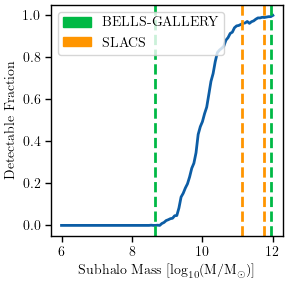

In [47]:
import matplotlib.patches as mpatches
c0_patch = mpatches.Patch(color='C1', label='BELLS-GALLERY')
c1_patch = mpatches.Patch(color='C2', label='SLACS')

plt.figure(figsize=(3, 3))
plt.plot(mlog10_list, percent_det)
for m in bells:
    plt.axvline(m, color='C1', linestyle='--')
for m in slacs:
    plt.axvline(m, color='C2', linestyle='--')
plt.ylabel('Detectable Fraction')
plt.xlabel(r'Subhalo Mass [$\log_{10}($M/M$_\odot)$]')
plt.legend(handles=[c0_patch, c1_patch])
plt.savefig(os.path.join(figure_dir, 'subhalo_detection_compare.png'))
plt.show()

In [ ]:
hst_masses = [11.91, 11.12, 11.75, 11.95]
hst_zs = [0.2219, 0.2270, 0.1045, 0.4980]

roman_masses = m_list
roman_zs = z_list

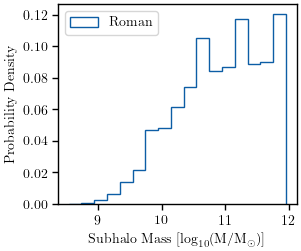

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(3, 2.5), constrained_layout=True)

binwidth = 0.2
bins = np.arange(min(roman_masses + hst_masses), max(roman_masses + hst_masses) + (binwidth / 2), binwidth)
# ax[0].hist(roman_masses, bins=bins)
ax.hist(roman_masses, label=f'Roman', bins=bins, histtype='step', weights=plot_util.weights(roman_masses))  # weights=plot_util.weights(roman_masses), 
# ax[0].hist(hst_masses, label=f'HST: {hst_masses_q[1]:.2f}' + r'$\substack{+0.17 \\ -1.52}$', bins=bins, weights=plot_util.weights(hst_masses))  # weights=plot_util.weights(hst_masses), 
# ax[0].axvline(roman_masses_q[0], color='C0', linestyle=':')
# ax[0].axvline(roman_masses_q[1], color='C0', linestyle='--')
# ax[0].axvline(roman_masses_q[2], color='C0', linestyle=':')
# ax[0].axvline(hst_masses_q[1], color='C1', linestyle='--')
ax.set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax.set_ylabel('Probability Density')
# ax[0].set_yscale('log')
# ax[0].set_ylim(0, 0.6)
ax.legend(loc='upper left')

plt.savefig(os.path.join(figure_dir, 'subhalo_detection_compare.png'))
plt.show()

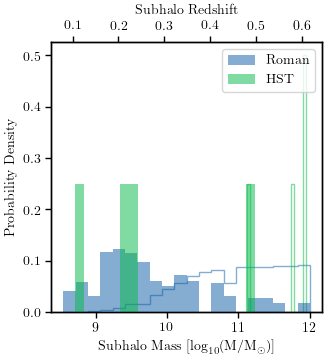

In [ ]:
f, ax1 = plt.subplots(figsize=(3.5, 3.5))
ax1.hist(roman_masses, bins=20, alpha=0.5, label='Roman', histtype='step', weights=plot_util.weights(roman_masses))
ax1.hist(hst_masses, bins=20, alpha=0.5, label='HST', histtype='step', weights=plot_util.weights(hst_masses))
ax1.set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax1.set_ylabel('Probability Density')

ax2 = ax1.twiny()
ax2.hist(roman_zs, bins=20, alpha=0.5, label='Roman', weights=plot_util.weights(roman_zs))
ax2.hist(hst_zs, bins=20, alpha=0.5, label='HST', weights=plot_util.weights(hst_zs))
ax2.set_xlabel('Subhalo Redshift')

plt.legend()
plt.show()

In [ ]:
q_low = 0.16
q_mid = 0.5
q_high = 0.84

roman_masses_q = np.quantile(roman_masses, [q_low, q_mid, q_high])
hst_masses_q = np.quantile(hst_masses, [q_low, q_mid, q_high])
roman_zs_q = np.quantile(roman_zs, [q_low, q_mid, q_high])
hst_zs_q = np.quantile(hst_zs, [q_low, q_mid, q_high])

roman_mass_high = roman_masses_q[2] - roman_masses_q[1]
roman_mass_low = roman_masses_q[1] - roman_masses_q[0]
hst_mass_high = hst_masses_q[2] - hst_masses_q[1]
hst_mass_low = hst_masses_q[1] - hst_masses_q[0]
roman_z_high = roman_zs_q[2] - roman_zs_q[1]
roman_z_low = roman_zs_q[1] - roman_zs_q[0]
hst_z_high = hst_zs_q[2] - hst_zs_q[1]
hst_z_low = hst_zs_q[1] - hst_zs_q[0]

print(f'{roman_masses_q[1]:.2f} +{roman_mass_high:.2f} -{roman_mass_low:.2f}')
print(f'{hst_masses_q[1]:.2f} +{hst_mass_high:.2f} -{hst_mass_low:.2f}')
print(f'{roman_zs_q[1]:.2f} +{roman_z_high:.2f} -{roman_z_low:.2f}')
print(f'{hst_zs_q[1]:.2f} +{hst_z_high:.2f} -{hst_z_low:.2f}')

11.03 +0.67 -0.79
11.83 +0.10 -0.41
0.24 +0.17 -0.08
0.22 +0.14 -0.06


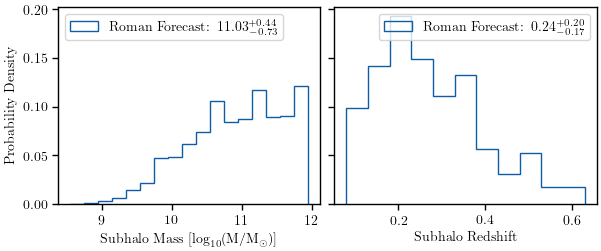

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True, constrained_layout=True)

binwidth = 0.2
bins = np.arange(min(roman_masses + hst_masses), max(roman_masses + hst_masses) + (binwidth / 2), binwidth)
# ax[0].hist(roman_masses, bins=bins)
ax[0].hist(roman_masses, label=f'Roman Forecast: {roman_masses_q[1]:.2f}' + r'$\substack{+0.44 \\ -0.73}$', bins=bins, histtype='step', weights=plot_util.weights(roman_masses))  # weights=plot_util.weights(roman_masses), 
# ax[0].hist(hst_masses, label=f'HST: {hst_masses_q[1]:.2f}' + r'$\substack{+0.17 \\ -1.52}$', bins=bins, weights=plot_util.weights(hst_masses))  # weights=plot_util.weights(hst_masses), 
# ax[0].axvline(roman_masses_q[0], color='C0', linestyle=':')
# ax[0].axvline(roman_masses_q[1], color='C0', linestyle='--')
# ax[0].axvline(roman_masses_q[2], color='C0', linestyle=':')
# ax[0].axvline(hst_masses_q[1], color='C1', linestyle='--')
ax[0].set_xlabel('Subhalo Mass [$\log_{10}$(M/M$_\odot$)]')
ax[0].set_ylabel('Probability Density')
# ax[0].set_yscale('log')
# ax[0].set_ylim(0, 0.6)
ax[0].legend(loc='upper left')

binwidth = 0.05
bins = np.arange(min(roman_zs + hst_zs), max(roman_zs + hst_zs) + (binwidth / 2), binwidth)
# ax[1].hist(roman_zs, bins=bins)
ax[1].hist(roman_zs, label=f'Roman Forecast: {roman_zs_q[1]:.2f}' + r'$\substack{+0.20 \\ -0.17}$', bins=bins, histtype='step', weights=plot_util.weights(roman_zs))  # , 
# ax[1].hist(hst_zs, label=f'HST: {hst_zs_q[1]:.2f}' + r'$\substack{+0.29 \\ -0.05}$', bins=bins, weights=plot_util.weights(hst_zs))  # , 
# ax[1].axvline(roman_zs_q[0], color='C0', linestyle=':')
# ax[1].axvline(roman_zs_q[1], color='C0', linestyle='--')
# ax[1].axvline(roman_zs_q[2], color='C0', linestyle=':')
# ax[1].axvline(hst_zs_q[1], color='C1', linestyle='--')
ax[1].set_xlabel('Subhalo Redshift')
# ax[1].set_ylabel('Count')
# ax[1].set_yscale('log')
# ax[1].set_ylim(1e-1, 2e5)
ax[1].legend(loc='upper right')

plt.savefig(os.path.join(figure_dir, 'subhalo_detection_compare.png'))
plt.show()

In [ ]:
# hst_detections = np.column_stack([hst_masses, hst_zs])

# hst = corner(hst_detections, labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'], color='r')

In [ ]:
# roman_detections = np.column_stack([roman_masses, roman_zs])

# roman = corner(roman_detections, color='b', labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'])

In [ ]:
# corner(hst_detections, labels=[r'$\log_{10}$(M$_\odot$)', r'$z$'], color='r', fig=roman)